In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.llamma import LLAMMA
from src.controller import Controller
from src.oracle import Oracle
from src.mpolicy import MonetaryPolicy
from src.liquidator import Liquidator
import pandas as pd
import numpy as np
from datetime import datetime
from src.utils import _plot_borrowers, gen_gbm
import matplotlib.pyplot as plt
from src.utils import external_swap
import copy

In [12]:
WINDOW = 600 # 10 minutes
BASE_PRICE = 1800
A = 100
FEE = 0.006
ADMIN_FEE = 1
LOAN_DISCOUNT = 0.09
LIQUIDATION_DISCOUNT = 0.06

N_BORROWERS = 100
VALUE = 60_000_000 # USD value of collateral
COINS = 60_000_000 / BASE_PRICE # Number of collateral coins
DEBT = 44_000_000 # crvUSD debt

TOLERANCE = 0 # Min profit for liquidator to act

START = int(datetime.now().timestamp())

oracle = Oracle(WINDOW)
oracle.update(START, BASE_PRICE) # set initial price
llamma = LLAMMA(A, BASE_PRICE, oracle, FEE, admin_fee=ADMIN_FEE)
mpolicy = MonetaryPolicy()
controller = Controller(llamma, mpolicy, LOAN_DISCOUNT, LIQUIDATION_DISCOUNT) 
liquidator = Liquidator(TOLERANCE)

TypeError: descriptor 'tolerance' for 'Liquidator' objects doesn't apply to a 'Liquidator' object

Total collateral: 60 Mns USD
Total debt: 38 Mns USD


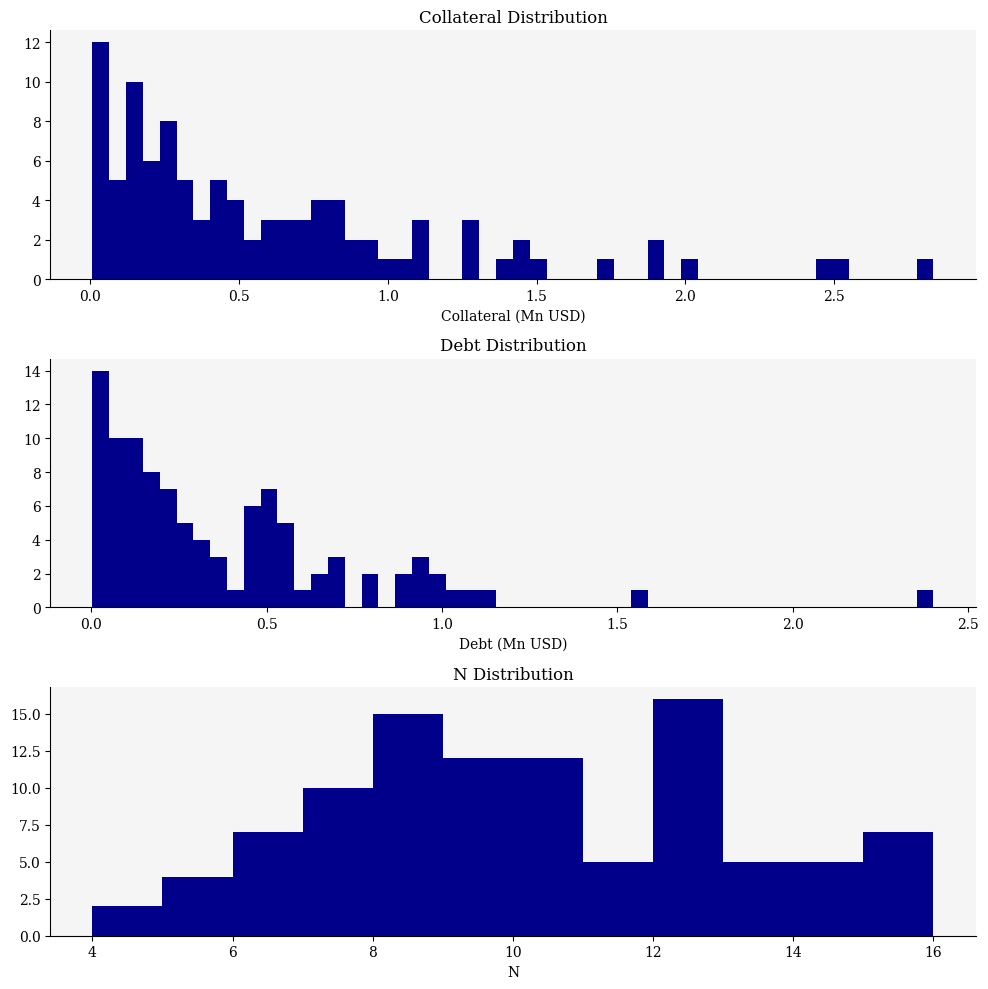

In [ ]:
borrowers = controller.gen_borrowers(N_BORROWERS, COINS, v=True)
_plot_borrowers(borrowers, BASE_PRICE)

In [13]:
# Check that this generate func will generally give us ~
debts = []
for _ in range(1000):
    bs = controller.gen_borrowers(N_BORROWERS, COINS)
    debts.append(bs[:,1].sum())
print(f"Mean debt: {round(np.mean(debts) / 1e6)} Mns USD")
print(f"Desired debt: {DEBT / 1e6} Mns USD")

Mean debt: 39 Mns USD
Desired debt: 44.0 Mns USD


In [14]:
for i, b in enumerate(borrowers):
    # Deposit!
    controller.create_loan(i, *b)

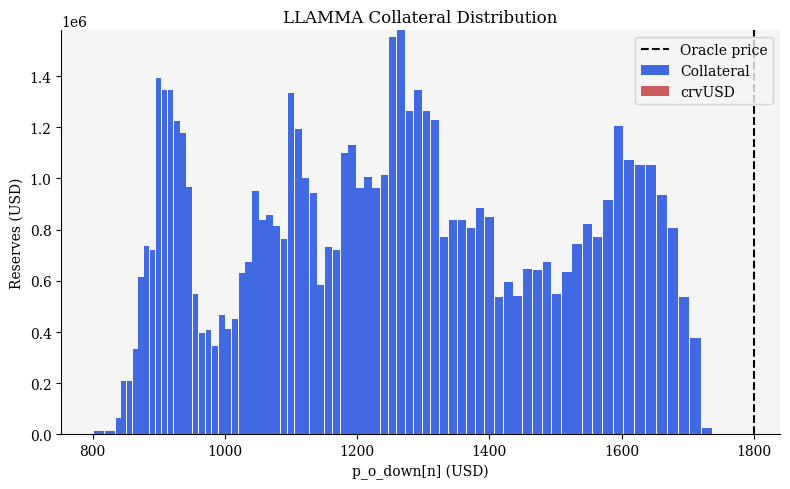

In [15]:
llamma.plot_reserves()

In [16]:
# NOTE run this to see that oracle updates affect llamma
# oracle.update(START + 60*60, BASE_PRICE * 0.9)
# llamma.plot_reserves()

1283.4130089685648

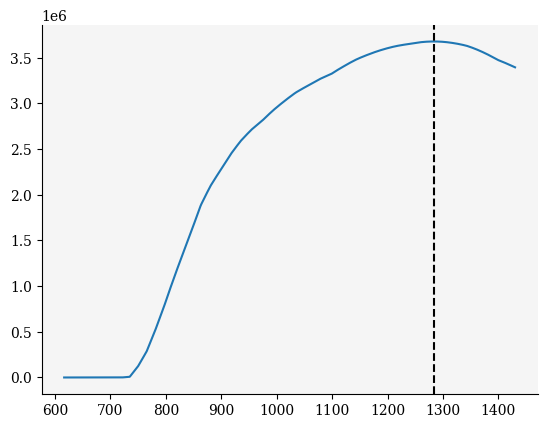

In [19]:
p_mkt = 1300 # <- target price for arbitrage

ext_stable_liquidity = 2e10 # NOTE very high, ~ no slippage
ext_collat_liquidity = ext_stable_liquidity / p_mkt # <- external liquidity is at market price
ext_swap_fee = 0.005

llamma_cp = copy.deepcopy(llamma)
oracle_cp = copy.deepcopy(llamma.oracle)
llamma_cp.oracle = oracle_cp
oracle_cp.update(START + 60*1000, p_mkt) # <- update oracle to be close to market price

p_opt = Liquidator.get_optimal_arb(llamma_cp, p_mkt, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
p_opt

In [20]:
amt_in, amt_out, pump = Liquidator.calc_arb_amounts(llamma_cp, p_opt)
llamma_cp.swap(amt_in, not pump)

(12325507.379992008, 12382.969804652012)

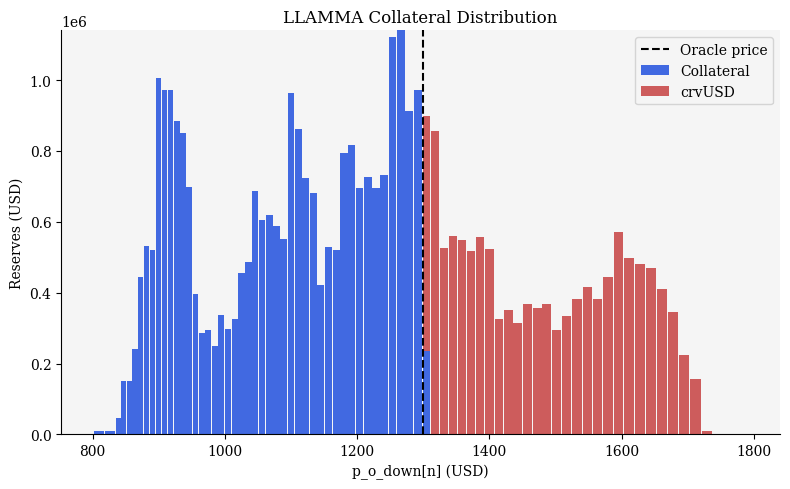

In [21]:
llamma_cp.plot_reserves()

In [30]:
n = llamma_cp.active_band
n, llamma_cp.p_c_down(n), llamma_cp.p_c_up(n), llamma_cp.p_o_up(n), llamma_cp.p_o_down(n)

(17,
 1086.657968384377,
 1108.7215267670413,
 1517.2977480910681,
 1502.1247706101574)

1086.657968384377

447.0152209375368 1800.0 1420.7276647028652
try: (1123.5076104687685, 270232.9849535227)
try: (1461.7538057343843, -694508.275891792)
try: (1292.6307081015764, -175413.532691136)
try: (1208.0691592851724, 127895.18986456376)
try: (1250.3499336933744, -7176.347015788779)
try: (1229.2095464892734, 63939.82454736531)
try: (1239.779740091324, 29108.185599585995)
try: (1245.0648368923491, 10927.364796794951)
try: (1247.7073852928618, 1901.0570756169036)
try: (1249.028659493118, -2622.6811153925955)
try: (1248.36802239299, -357.06486747041345)
try: (1248.037703842926, 772.9336662162095)
try: (1248.202863117958, 208.1686919806525)
try: (1248.285442755474, -74.38952854834497)
try: (1248.244152936716, 66.90422343369573)
try: (1248.264797846095, -3.7389920754358172)
try: (1248.2544753914055, 31.58353411965072)
try: (1248.2596366187504, 13.922497782856226)
try: (1248.2622172324227, 5.091812390834093)
try: (1248.2635075392589, 0.6764221917837858)
try: (1248.2641526926768, -1.5312776528298855)
try:

(1123.5076104687682, 1420.7276647028652, 1200)

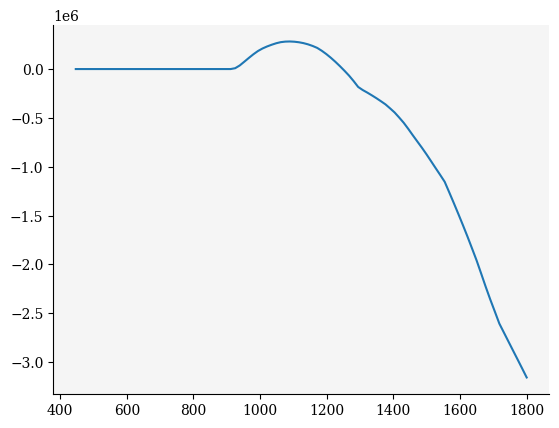

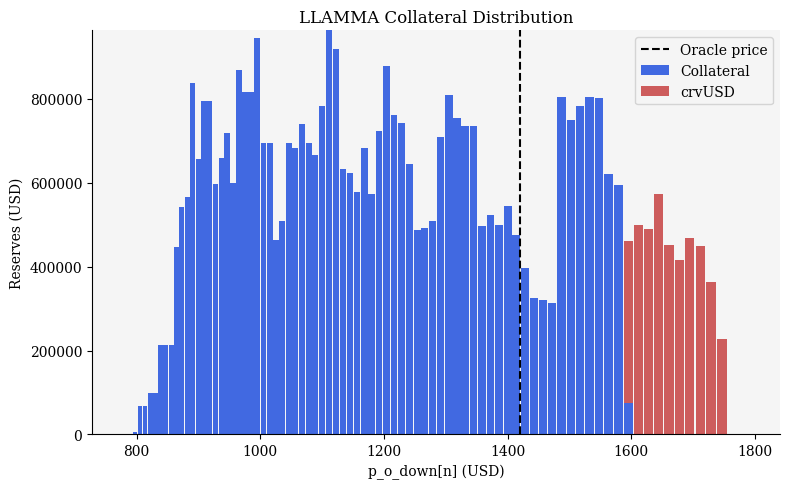

In [41]:
p_mkt = 1200

llamma.oracle.update(START + 60*10, p_mkt)

optimal_price = binary_search_p_new(llamma, p_mkt, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)

print(optimal_price)

optimal_in, optimal_out, pump = calc_arb_amounts(llamma, optimal_price)

llamma.swap(optimal_in, not pump)

llamma.plot_reserves()

llamma.p, llamma.p_o, p_mkt

In [43]:
optimal_price = binary_search_p_new(llamma, p_mkt, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)

561.7538052343841 1800.0 1420.7276647028652
try: (1180.8769026171922, -72676.07016457967)


AssertionError: 

In [40]:
# Now let's create some dummy prices and assume that liquidators
# will liquidate when profitable.

WINDOW = 3600 # 1 hrs # NOTE this is way longer than the actual contract
PERIOD = 86400 # 1 day

times = [int(START + dt*60) for dt in range(0, PERIOD//60)]

df = pd.DataFrame(columns=['timestamp', 'spot', 'oracle', 'liquidation_pnl'])
df['timestamp'] = times
df.index = pd.to_datetime(df['timestamp'], unit='s')
df['spot'] = gen_gbm(S0=BASE_PRICE,mu=0.05, sigma=0.2, dt=1/1440,T=1)
df.head()

,timestamp,spot,oracle,liquidation_pnl
timestamp,,,,
2023-10-18 16:52:20,1697647940,1797.469093,NaN,NaN
2023-10-18 16:53:20,1697648000,1794.763596,NaN,NaN
2023-10-18 16:54:20,1697648060,1786.751559,NaN,NaN
2023-10-18 16:55:20,1697648120,1807.257344,NaN,NaN
2023-10-18 16:56:20,1697648180,1799.513523,NaN,NaN


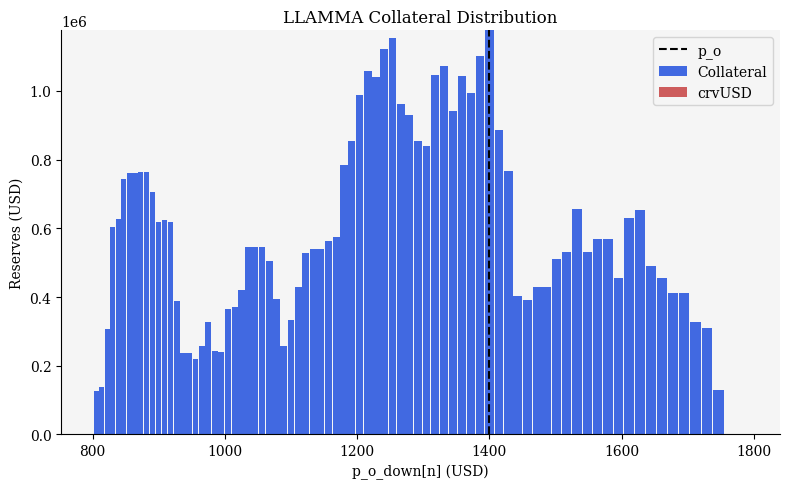

In [41]:
oracle.update(START + 60 * 100, 1400)
llamma.plot_reserves()

In [42]:
# everything above band 24 (i.e. < 24) should be in stablecoin
for i in range(24, 0, -1):
    amt = llamma.bands_y[i] 
    llamma.bands_x[i] = amt * llamma.p_o
    llamma.bands_y[i] = 0

amt = llamma.bands_x[24]
llamma.bands_x[24] = amt / 2
llamma.bands_y[24] = amt / 2 / llamma.p_o

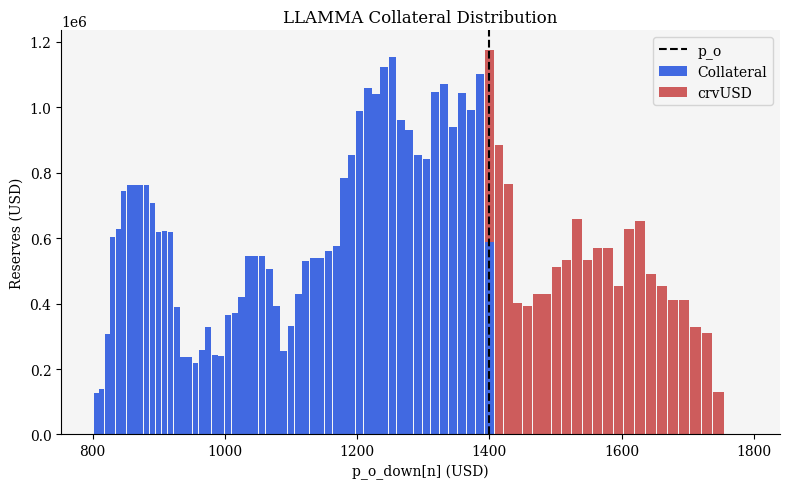

In [43]:
oracle.update(START + 60 * 100, 1400)
llamma.plot_reserves()

In [44]:
spot = BASE_PRICE
n = llamma.active_band
if spot < llamma.p():
    y_new = (llamma.inv(n) / spot) ** 0.5 - llamma.g(n)
    if y_new < 0:
        

SyntaxError: incomplete input (3252540118.py, line 6)

In [ ]:
spot = BASE_PRICE
n = llamma.active_band
y_new = (llamma.inv(n) / spot) ** 0.5 - llamma.g(n)
y_new

0.0

In [ ]:
llamma.y0(n)

0.0

In [ ]:
# TODO arbitrage doesn't work because invariant is zero when x = 0
# actually it's probs because there's x=y=0 rn, so just need to take us to the right band

In [ ]:
# Init external market liquidity for slippage calc
ext_stable_liquidity = 2e8 # NOTE why 2M?
ext_collat_liquidity = ext_stable_liquidity / BASE_PRICE
ext_swap_fee = 0.005

# Run simulation
for i, row in df.iterrows():
    
    # Update oracle
    ema_price = oracle.update(row['timestamp'], row['spot'])
    df.loc[i, 'oracle'] = ema_price

    # Update external liquidity
    ext_collat_liquidity = ext_stable_liquidity / row['spot']

    # Check for liquidations
    liquidator.perform_liquidations(controller, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
    df.loc[i, 'liquidation_pnl'] = liquidator.pnl
    
    # Check for arbitrage
    

No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to liquidate.
No users to

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''